In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

plt.rc('font', family='serif')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10, color='grey')
plt.rc('ytick', labelsize=10, color='grey')
plt.rc('legend', fontsize=12, loc='lower left')
plt.rc('figure', titlesize=12)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from calendar import day_abbr, month_abbr, mdays

In [3]:
import sys
PATH_TO_ROOT = 'C:\\Users\\kushs\\Downloads\\Electricity usage prediction\\Electricity usage prediction'
sys.path.insert(0,PATH_TO_ROOT)

In [4]:
def generate_fig_path(fig_name):
    
    return '{}/results/fig/results_data/{}'.format(PATH_TO_ROOT, fig_name)

def generate_data_path(data_name):
    
    return '{}/data/{}.csv'.format(PATH_TO_ROOT, data_name)

## Read data

In [5]:
mum = pd.read_csv(generate_data_path('power/mum_load'),index_col=0)
mum.index = pd.to_datetime(mum.index)
mum['load'] = mum['load']/1000              

hyd = pd.read_csv(generate_data_path('power/hyd_load'),index_col=0)
hyd.index = pd.to_datetime(hyd.index)
hyd['load'] = hyd['load']/1000

delhi = pd.read_csv(generate_data_path('power/delhi_load'),index_col=0)
delhi.index = pd.to_datetime(delhi.index)
delhi['load'] = delhi['load']/1000

## Figure 3

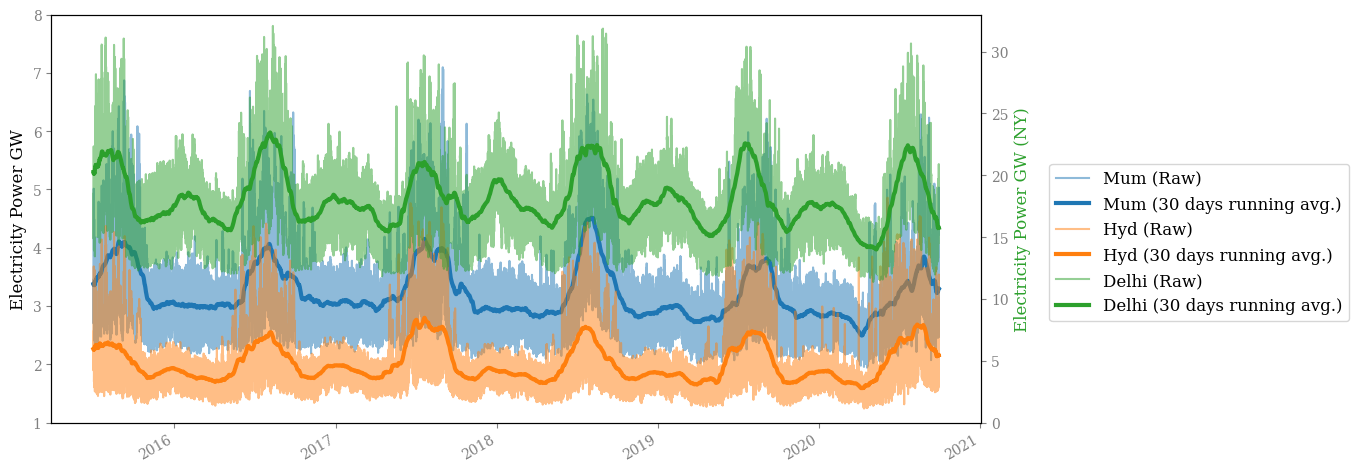

In [6]:
f, ax1 = plt.subplots(figsize=(12,6))
mum['load'].plot(ax=ax1, color=default_colors[0], alpha=0.5, label='Mum (Raw)')
mum['load'].rolling(window=30*24, center=True,min_periods=1).mean().plot(
    ax=ax1,lw=3,color=default_colors[0],label='Mum (30 days running avg.)')
hyd['load'].plot(ax=ax1, color=default_colors[1], alpha=0.5, label='Hyd (Raw)')
hyd['load'].rolling(window=30*24, center=True,min_periods=1).mean().plot(
    ax=ax1,lw=3,color=default_colors[1],label='Hyd (30 days running avg.)')
ax1.set_ylabel('Electricity Power GW')
ax1.set_ylim(1,8)

ax2 = ax1.twinx()
delhi['load'].plot(ax=ax2, color=default_colors[2], alpha=0.5, label='Delhi (Raw)')
delhi['load'].rolling(window=30*24, center=True,min_periods=1).mean().plot(
    ax=ax2,lw=3,color=default_colors[2],label='Delhi (30 days running avg.)')
ax2.set_ylabel('Electricity Power GW (NY)', color=default_colors[2])
ax2.set_ylim(0,33)
f.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))

plt.savefig(generate_fig_path('Figure 3'))

## Figure 4

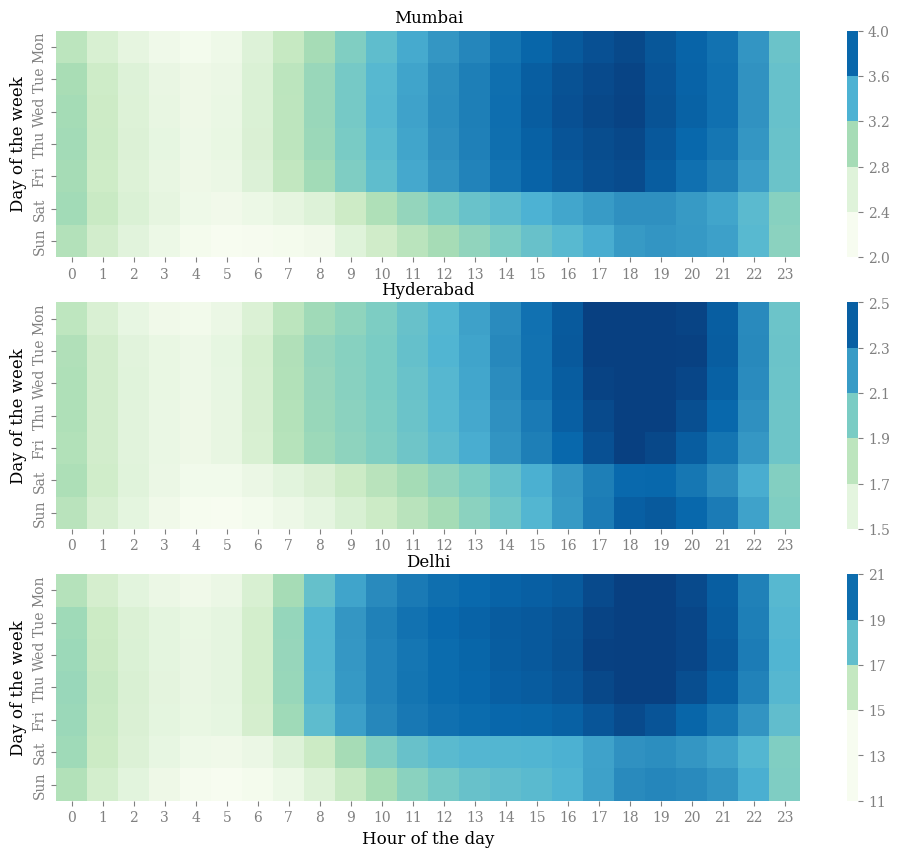

In [7]:
data_dict = {0: [mum, 'Mumbai', 2, 4, 0.4],
             1: [hyd, 'Hyderabad', 1.5, 2.5, 0.2],
             2: [delhi, 'Delhi', 11, 21, 2]}

fig, axes = plt.subplots(3, 1, figsize=(12,10))
for i in range(3):
    data = data_dict[i][0]
    file_name = data_dict[i][1]
    ax = axes[i]
    
    hour_week = pd.DataFrame({'load':data.loc[:,'load']})
    hour_week['day_of_week'] = hour_week.index.dayofweek
    hour_week['hour'] = hour_week.index.hour
    hour_week = hour_week.groupby(['day_of_week','hour']).mean().unstack()
    hour_week.columns = hour_week.columns.droplevel(0)

    sns.heatmap(hour_week, ax = ax, cmap=plt.cm.GnBu, vmax=data_dict[i][3],
                cbar_kws={'boundaries':np.arange(data_dict[i][2],data_dict[i][3]+0.1,data_dict[i][4])})
    cbax = f.axes[1]
    cbax.set_ylabel('Electricity Power GW')
    ax.set_xlabel('\n')
    ax.set_ylabel('Day of the week')
    ax.set_yticklabels(day_abbr[0:7])
    ax.set_title(data_dict[i][1])

for ax in fig.get_axes():
    ax.label_outer()
    
axes[2].set_xlabel('Hour of the day')
fig.savefig(generate_fig_path('Figure 4'))

## Figure 5

In [8]:
def add_holiday_weekend(data):
    
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
    cal = calendar()
    holidays = cal.holidays(start=data.index.min(), end=data.index.max())
    data['Holiday'] = data.index.isin(holidays)

    data['Weekend'] = data.index.weekday > 4
    
    data['Non-workDay'] = data['Holiday'] | data['Weekend']
    data['Day Type'] = data['Non-workDay'].apply(lambda x : 'Non-Working Day' if x else 'Working Day')

    return data

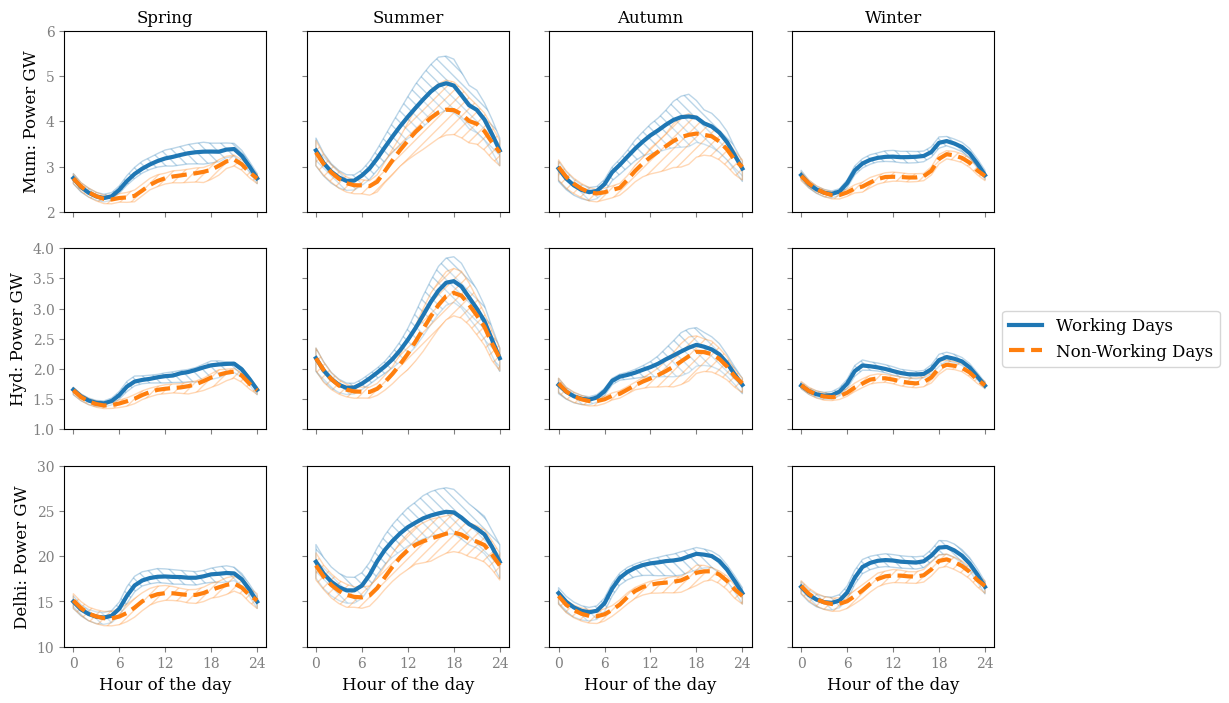

In [9]:
data_dict = {'LADPW': [mum, 2, 6],
             'BANC': [hyd, 1, 4],
             'NYISO': [delhi, 10, 30]}
city_dict = {'LADPW': 'Mum',
             'BANC': 'Hyd',
             'NYISO': 'Delhi'}
season_dict = {'Spring': [3,4,5], 'Summer': [6,7,8], 'Autumn': [9, 10, 11], 'Winter': [12, 1, 2]}

fig, axs = plt.subplots(3, 4, figsize=(12,8))



i = 0

for region in data_dict.keys():
    data = data_dict[region][0]
    y_min = data_dict[region][1]
    y_max = data_dict[region][2]
    
    data = add_holiday_weekend(data)

    j = 0
    
    for season in season_dict.keys():
        data_season = data.loc[data.index.month.isin(season_dict[season]), ['load','Day Type']]
        workingday = data_season.loc[data_season['Day Type']=='Working Day', 'load']
        nonworkingday = data_season.loc[data_season['Day Type']=='Non-Working Day', 'load']
        summary_hour_workingday = workingday.groupby(workingday.index.hour).describe()
        summary_hour_nonworkingday = nonworkingday.groupby(nonworkingday.index.hour).describe()
        summary_hour_workingday.loc[24] = summary_hour_workingday.loc[0]
        summary_hour_nonworkingday.loc[24] = summary_hour_nonworkingday.loc[0]
        
        axs[i, j].plot(summary_hour_workingday.index, summary_hour_workingday.loc[:,'mean'], 
                             color=default_colors[0],label='Working Days', lw=3)
        axs[i, j].fill_between(summary_hour_workingday.index, summary_hour_workingday.loc[:,'25%'], 
                                     summary_hour_workingday.loc[:,'75%'], 
                                     color=default_colors[0], hatch='\\\\\\', facecolor='1', alpha=0.3)

        axs[i, j].plot(summary_hour_nonworkingday.index, summary_hour_nonworkingday.loc[:,'mean'], 
                             color=default_colors[1], label='Non-Working Days', ls='--', lw=3)
        axs[i, j].fill_between(summary_hour_nonworkingday.index, summary_hour_nonworkingday.loc[:,'25%'], 
                                     summary_hour_nonworkingday.loc[:,'75%'], 
                                     color=default_colors[1], hatch='///', facecolor='1', alpha=0.3)        
        axs[i, j].set_ylim([y_min, y_max])
        j += 1
        
    axs[i, 0].set(ylabel=f'{city_dict[region]}: Power GW')
    
    i += 1

for j in range(4):
    axs[0, j].set_title(list(season_dict.keys())[j], fontsize=12)
    

for ax in axs.flat:
    ax.set(xlabel='Hour of the day')
    ax.set_xticks(range(0, 25, 6))
    ax.label_outer()     

axs[2,3].legend(loc='center left', bbox_to_anchor=(1,1.7))

fig.savefig(generate_fig_path('Figure 5'))